# PREPARATION

In [1]:
from typing import Any
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import numpy as np
from utils import MaxHeap

In [2]:
df = pd.read_csv("run/accuracy/datasets/ag_news.csv")
display(df.columns)

df = df[~df["label"].isna()]
display(len(df))

Index(['original_jsonl_row_index', 'label', 'title', 'description',
       'llama-2-7b-it', 'llama-3.1-70b-it', 'Phi-3-Mini-128K-it',
       'TinyLlama-1.1B-it'],
      dtype='object')

7600

In [3]:
UNIQUE_LABELS = [0, 1, 2, 3, 4]
NUM_TRIALS = 10
GAP = 1
ALPHA = 0.35
TOPK = int(len(df) * 0.1)
WITH_REPLACEMENT = False
INDICES = list(range(len(df)))
MODELS = ['llama-2-7b-it', 'llama-3.1-70b-it', 'Phi-3-Mini-128K-it',
       'TinyLlama-1.1B-it']
SHORT_NAMES = {
    'gemma-2-2b-it': '2b', 'Mistral-7B-Instruct': '7b',
       'gemma-3-1b-it': '1b', 'gemma-3-4b-it': '4b', 'gemma-3-270m-it': '270m',
       'Qwen/Qwen2.5-1.5B-Instruct': '1.5b', 'Qwen/Qwen2.5-3B-Instruct': '3b', 
       'llama-3.1-70b-it': '70b', 'bloomz-1b7': '1.7b',
       'TinyLlama-1.1B-it': '1.1b', 'Phi-3-Mini-128K-it': '3.8b',
        'llama-2-7b-it': '7b'
}
NUM_LLMS = len(MODELS)
ACC = {}
for model in MODELS:
    ACC[model] =(df["label"] == df[model]).sum()
ACC

{'llama-2-7b-it': 2206,
 'llama-3.1-70b-it': 6621,
 'Phi-3-Mini-128K-it': 4787,
 'TinyLlama-1.1B-it': 1297}

# UNWEIGHTED VOTING

In [4]:
# unweighted voting
def most_votes_win(df) -> int:
    """Returns accuracy based on unweighted voting."""
    correct = 0
    for _, row in df.iterrows():
        votes = {label: 0 for label in UNIQUE_LABELS}
        for model in MODELS:
            prediction = row[model]
            votes[prediction] += 1
        # Find label with most votes
        winning_label = max(votes, key=votes.get)
        if winning_label == row['label']:
            correct += 1
    return correct
ACC["unweighted"] = most_votes_win(df)
display(ACC["unweighted"])


5498

# WEIGHTED VOTING + DISAGREEMENT-BASED SAMPLE SELECTION

In [5]:
def plot_weight_and_accuracy(weight_evolution: list[list[float]], models: list[str], accuracies: dict) -> None:
    if not weight_evolution:
        raise ValueError("weight_evolution is empty")

    # Transpose → each entry is weight history for one model
    per_model_weights = list(zip(*weight_evolution))

    plt.figure(figsize=(8, 5))

    for model, weights in zip(models, per_model_weights):
        acc = accuracies[model]
        plt.plot(weights, label=f"{SHORT_NAMES[model]} (acc={acc})")

    plt.xticks(range(len(weight_evolution)), [i * GAP for i in range(len(weight_evolution))])
    plt.xlabel("Trial")
    plt.ylabel("Weight")
    plt.title("Weight Evolution with Final Accuracies")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
# weighted voting 
def weighted_voting(df, wdict: dict[str, float]) -> int:
    """Returns accuracy based on unweighted voting."""
    correct = 0
    for _, row in df.iterrows():
        votes = {label: 0 for label in UNIQUE_LABELS}
        for model in MODELS:
            prediction = row[model]
            votes[prediction] += wdict[model]
        # Find label with most votes
        winning_label = max(votes, key=votes.get)
        if winning_label == row['label']:
            correct += 1
    return correct

In [7]:
def mwu(df: pd.DataFrame, 
        index_range: list, 
        num_sams: int, 
        alpha: float, 
        topK: int,
        seed: int) -> tuple[list[list[float]], list[float]]:
    """Returns weight evolution based on Hedge rule"""
    random.seed(seed)

    weights = [1.] * NUM_LLMS

    weight_evolution = [weights.copy()]

    for _ in range(1, num_sams+1): 
        # disagreement-based sample selection
        eligible = MaxHeap()
        for index in index_range:
            row = df.iloc[index]
            votes = {label: 0. for label in UNIQUE_LABELS}
            for model_index, model in enumerate(MODELS):
                prediction = row[model]
                votes[prediction] += weights[model_index]
            # Find label with most votes
            winning_label = max(votes, key=votes.get)
            cur_max_load = votes[winning_label]
            if len(eligible) < topK:
                eligible.push(index, cur_max_load)
            elif eligible.peek()[1] > cur_max_load:
                eligible.pop()
                eligible.push(index, cur_max_load)

        # Update weights based on best_index
        best_index = random.choice(eligible._data)[1] # sample one at random from the list of best_indices
        best_row = df.iloc[best_index]
        for model_index, model in enumerate(MODELS):
            prediction = best_row[model]
            if prediction != best_row['label']:
                weights[model_index] *= math.exp(-alpha)
        
        # track weight evolution
        weight_evolution.append(weights.copy())

        # Remove best_index from index_range
        if not WITH_REPLACEMENT:
            index_range.remove(best_index)
    return weight_evolution, weights

In [8]:
seed = 10

df_s10 = df.sample(frac=1, random_state=seed).reset_index(drop=True)

weight_evolution_disagreement_s10, final_weights_disagreement = mwu(df_s10, 
                                                                INDICES.copy(), 
                                                                NUM_TRIALS, ALPHA, TOPK, seed)

wdict_disagreement: dict = {}
for model, weight in zip(MODELS, final_weights_disagreement):
    wdict_disagreement[model] = weight
display(wdict_disagreement)

ACC[f"weighted_disagreement_seed{seed}"] = weighted_voting(df, wdict_disagreement)
display(ACC[f"weighted_disagreement_seed{seed}"])


{'llama-2-7b-it': 0.06081006262521797,
 'llama-3.1-70b-it': 0.4965853037914095,
 'Phi-3-Mini-128K-it': 0.04285212686704019,
 'TinyLlama-1.1B-it': 0.04285212686704019}

6621

In [9]:
seed = 20

df_s20 = df.sample(frac=1, random_state=seed).reset_index(drop=True)

weight_evolution_disagreement_s20, final_weights_disagreement = mwu(df_s20, 
                                                                INDICES.copy(), 
                                                                NUM_TRIALS, ALPHA, TOPK, seed)

wdict_disagreement: dict = {}
for model, weight in zip(MODELS, final_weights_disagreement):
    wdict_disagreement[model] = weight
display(wdict_disagreement)

ACC[f"weighted_disagreement_seed{seed}"] = weighted_voting(df, wdict_disagreement)
display(ACC[f"weighted_disagreement_seed{seed}"])


{'llama-2-7b-it': 0.030197383422318504,
 'llama-3.1-70b-it': 0.7046880897187134,
 'Phi-3-Mini-128K-it': 0.030197383422318504,
 'TinyLlama-1.1B-it': 0.04285212686704019}

6621

In [10]:
seed = 30

df_s30 = df.sample(frac=1, random_state=seed).reset_index(drop=True)

weight_evolution_disagreement_s30, final_weights_disagreement = mwu(df_s30, 
                                                                INDICES.copy(), 
                                                                NUM_TRIALS, ALPHA, TOPK, seed)

wdict_disagreement: dict = {}
for model, weight in zip(MODELS, final_weights_disagreement):
    wdict_disagreement[model] = weight
display(wdict_disagreement)

ACC[f"weighted_disagreement_seed{seed}"] = weighted_voting(df, wdict_disagreement)
display(ACC[f"weighted_disagreement_seed{seed}"])


{'llama-2-7b-it': 0.04285212686704019,
 'llama-3.1-70b-it': 0.7046880897187134,
 'Phi-3-Mini-128K-it': 0.030197383422318504,
 'TinyLlama-1.1B-it': 0.030197383422318504}

6621

In [11]:
ACC["weighted_disagreement"] = (ACC[f"weighted_disagreement_seed10"] +
                         ACC[f"weighted_disagreement_seed20"] +
                         ACC[f"weighted_disagreement_seed30"]) / 3
display(ACC["weighted_disagreement"])

6621.0

In [12]:
weight_evolution_disagreement = []
for (list1, list2, list3) in zip(weight_evolution_disagreement_s10, 
                                          weight_evolution_disagreement_s20, 
                                          weight_evolution_disagreement_s30):
    avg = np.mean([list1, list2, list3], axis=0).tolist()
    weight_evolution_disagreement.append(avg.copy())

# WEIGHTED VOTING + RANDOM SAMPLES

In [13]:
def mwu_random_samples(df: pd.DataFrame, 
        index_range: list, 
        num_sams: int = 10, 
        alpha: float = 0.35, 
        seed: int = 10) -> list[list[float]]:
    """Returns weight evolution based on Hedge rule"""
    random.seed(seed)

    weights = [1.] * NUM_LLMS

    weight_evolution = [weights.copy()]

    for _ in range(1, num_sams+1):
        chosen_index = random.choice(index_range)

        # Update weights based on best_index
        chosen_row = df.iloc[chosen_index]
        for model_index, model in enumerate(MODELS):
            prediction = chosen_row[model]
            if prediction != chosen_row['label']:
                weights[model_index] *= math.exp(-alpha)
        
        # track weight evolution
        weight_evolution.append(weights.copy())

        # Remove best_index from index_range
        index_range.remove(chosen_index)
    return weight_evolution, weights

In [14]:
seed = 10
weight_evolution_rand_s10, final_weights_rand = mwu_random_samples(df, 
                                                                   INDICES.copy(), 
                                                                   NUM_TRIALS, ALPHA, seed)
# final weights dict
wdict_rand = {}
for model, weight in zip(MODELS, final_weights_rand):
    wdict_rand[model] = weight

ACC[f"weighted_random_seed{seed}"] = weighted_voting(df, wdict_rand)
display(ACC[f"weighted_random_seed{seed}"])

6621

In [15]:
seed = 20
weight_evolution_rand_s20, final_weights_rand = mwu_random_samples(df, 
                                                                   INDICES.copy(), 
                                                                   NUM_TRIALS, ALPHA, seed)
# final weights dict
wdict_rand = {}
for model, weight in zip(MODELS, final_weights_rand):
    wdict_rand[model] = weight

ACC[f"weighted_random_seed{seed}"] = weighted_voting(df, wdict_rand)
display(ACC[f"weighted_random_seed{seed}"])

6621

In [16]:
seed = 30
weight_evolution_rand_s30, final_weights_rand = mwu_random_samples(df, 
                                                                   INDICES.copy(), 
                                                                   NUM_TRIALS, ALPHA, seed)
# final weights dict
wdict_rand = {}
for model, weight in zip(MODELS, final_weights_rand):
    wdict_rand[model] = weight

ACC[f"weighted_random_seed{seed}"] = weighted_voting(df, wdict_rand)
display(ACC[f"weighted_random_seed{seed}"])

6621

In [17]:
ACC["weighted_random"] = (ACC[f"weighted_random_seed10"] +
                         ACC[f"weighted_random_seed20"] +
                         ACC[f"weighted_random_seed30"]) / 3
display(ACC["weighted_random"])

6621.0

In [18]:
weight_evolution_rand = []
for (list1, list2, list3) in zip(weight_evolution_rand_s10, 
                                          weight_evolution_rand_s20, 
                                          weight_evolution_rand_s30):
    avg = np.mean([list1, list2, list3], axis=0).tolist()
    weight_evolution_rand.append(avg.copy())

# FINAL TOUCH

In [19]:
avg = 0
for model in MODELS:
    avg += ACC[model]
avg /= len(MODELS)

ACC["average_llms"] = avg

In [20]:
ACC

{'llama-2-7b-it': 2206,
 'llama-3.1-70b-it': 6621,
 'Phi-3-Mini-128K-it': 4787,
 'TinyLlama-1.1B-it': 1297,
 'unweighted': 5498,
 'weighted_disagreement_seed10': 6621,
 'weighted_disagreement_seed20': 6621,
 'weighted_disagreement_seed30': 6621,
 'weighted_disagreement': 6621.0,
 'weighted_random_seed10': 6621,
 'weighted_random_seed20': 6621,
 'weighted_random_seed30': 6621,
 'weighted_random': 6621.0,
 'average_llms': 3727.75}

In [21]:
def plot_improvement(methods: list[str], accuracy: list[float]):
    # PowerPoint-friendly style settings
    plt.rcParams.update({
        "font.family": "sans-serif",
        "font.size": 16,
        "axes.titlesize": 22,
        "axes.labelsize": 18,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "lines.linewidth": 4,
    })


    df = pd.DataFrame({"Method": methods, "Accuracy": accuracy})

    plt.figure(figsize=(12, 6))

    # Use a strong PowerPoint-friendly color
    plt.plot(
        df["Method"],
        df["Accuracy"],
        marker="o",
        markersize=12,
        color="#1f77b4",       # clean blue
    )

    # Label each point clearly
    for x, y in zip(df["Method"], df["Accuracy"]):
        if y == accuracy[-1]:
            plt.text(x, y - (max(accuracy) * 0.01), f"{y:,.2f}", ha="center", fontsize=14, va="top")
        elif y == accuracy[-2]:
            plt.text(x, y - (max(accuracy) * 0.01), f"{y:,.2f}", ha="center", fontsize=14, va="top")
        else:
            plt.text(x, y + (max(accuracy) * 0.01), f"{y:,.2f}", ha="center", fontsize=14, va="bottom")

    plt.title("Correctness Improvement", fontweight="bold")
    # plt.ylabel("correct answers")
    plt.ylabel("accuracy (%)")

    plt.yticks([])

    # Clean, subtle grid
    plt.grid(True, linestyle="--", alpha=0.25)

    # Extra spacing for PowerPoint export
    plt.xticks(rotation=25, ha="right")
    plt.gcf().subplots_adjust(top=0.88, bottom=0.22)
    plt.tight_layout()
    plt.show()


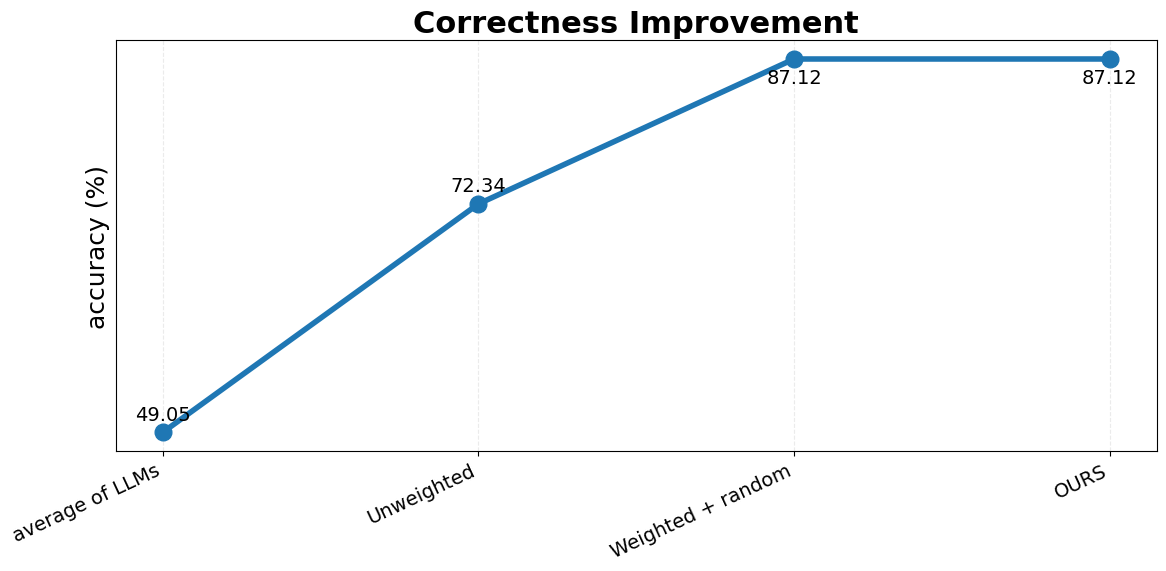

In [22]:

methods = [
    "average of LLMs",
    "Unweighted",
    "Weighted + random",
    "OURS",
]

accuracy = [
    ACC["average_llms"]/len(df) * 100,
    ACC["unweighted"]/len(df) * 100,
    ACC["weighted_random"]/len(df) * 100,
    ACC["weighted_disagreement"]/len(df) * 100
]

plot_improvement(methods, accuracy)


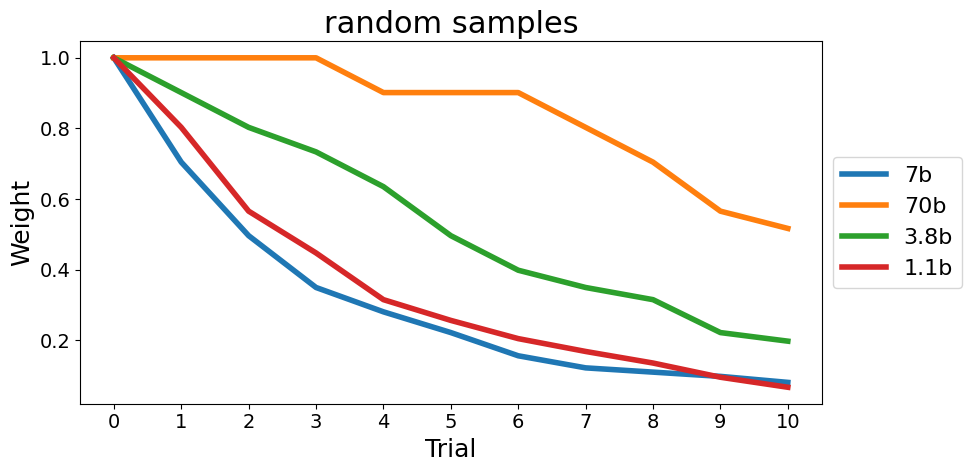

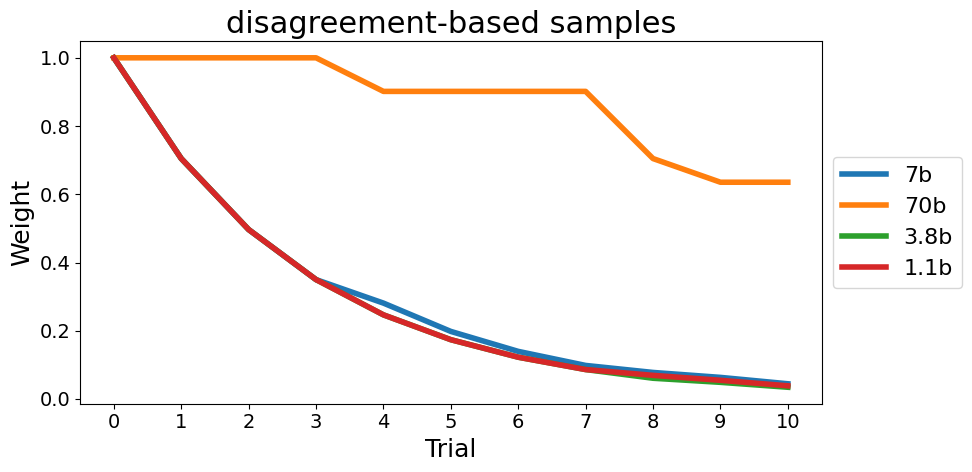

In [23]:
def plot_weight_evolution(weight_evolution: list[list[float]], models: list[str], subtitle: str) -> None:
    if not weight_evolution:
        raise ValueError("weight_evolution is empty")

    # Transpose → each entry is weight history for one model
    per_model_weights = list(zip(*weight_evolution))

    plt.figure(figsize=(10, 5))
    # plt.figure(figsize=(12, 6))

    for model, weights in zip(models, per_model_weights):
        plt.plot(weights, label=f"{SHORT_NAMES[model]}")

    plt.xticks(range(len(weight_evolution)), [i * GAP for i in range(len(weight_evolution))])
    plt.xlabel("Trial")
    plt.ylabel("Weight")
    # plt.title("Weight Evolution")
    plt.title(subtitle)

    plt.legend(
    loc="center left",       # place legend to the right
    bbox_to_anchor=(1, 0.5), # anchor to middle right outside the axes
    frameon=True
    )
    plt.tight_layout()
    plt.show()


plot_weight_evolution(weight_evolution_rand, MODELS, subtitle = "random samples")
plot_weight_evolution(weight_evolution_disagreement, MODELS, subtitle = "disagreement-based samples")